<a href="https://colab.research.google.com/github/naguzmans/opportunistic-utm/blob/master/02_Preprocess_Flight_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Dependencies

In [ ]:
!pip install pyspark
!pip install haversine
!pip install contextily
!pip install pyproj

In [ ]:
home_folder = '/content/drive/MyDrive/opportunistic-utm'

# Load CSV Data Into Spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
from pyspark.sql.functions import udf
import os
import glob
import datetime
from haversine import haversine, Unit, inverse_haversine
import numpy as np

spark = SparkSession.builder.appName('opensky').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

schema = StructType([ \
    StructField('time', LongType(), False), \
    StructField('icao24', StringType(), True), \
    StructField('lat', FloatType(), True), \
    StructField('lon', FloatType(), True), \
    StructField('velocity', FloatType(), True), \
    StructField('heading', FloatType(), True), \
    StructField('vertrate', FloatType(), True), \
    StructField('callsign', StringType(), True), \
    StructField('onground', BooleanType(), True), \
    StructField('alert', BooleanType(), True), \
    StructField('spi', BooleanType(), True), \
    StructField('squawk', FloatType(), True), \
    StructField('baroaltitude', FloatType(), True), \
    StructField('geoaltitude', FloatType(), True), \
    StructField('lastposupdate', FloatType(), True), \
    StructField('lastcontact', FloatType(), True), \
    StructField('hour', LongType(), True) \
])

def epoch_to_utc(hour_in_unix_time):
  return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
utc = udf(epoch_to_utc, DateType())

file_names = []

for filename in glob.iglob(f'{home_folder}/data/**/*.csv', recursive=True):
  file_names.append(filename)

opensky_df = spark.read.option('header', True).csv(path=file_names, schema=schema)
opensky_df = opensky_df.withColumn('timestamp', utc('hour'))

# opensky_df = opensky_df.sort('time')
opensky_df.show(10)

+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+----------+
|      time|icao24|      lat|         lon|velocity|  heading|vertrate|callsign|onground|alert|  spi|squawk|baroaltitude|geoaltitude|lastposupdate|lastcontact|      hour| timestamp|
+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+----------+
|1497139225|400755|51.918453| -0.11943708| 72.8715|255.27702|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|2017-06-11|
|1497139226|400755|51.918274| -0.12046814|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|2017-06-11|
|1497139227|400755|51.918083|-0.121398926|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|f

**Area subset**

In [ ]:
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 4

min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

area_subset = opensky_df.where(
                                (opensky_df.lat >= min_lat) &
                                (opensky_df.lat < max_lat) &
                                (opensky_df.lon >= min_lon) &
                                (opensky_df.lon < max_lon) 
                              )


**Verify schema**

In [ ]:
opensky_df.printSchema()

**Check rows and columns**

In [ ]:
print((opensky_df.count(), len(opensky_df.columns)))

(73780207, 18)


# Plot Hourly Data

In [ ]:
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
from pyspark.sql.functions import days
%config InlineBackend.figure_format = 'retina'

subset = area_subset.groupBy('timestamp', 'hour').agg(countDistinct('icao24'), countDistinct('time'))
df = subset.toPandas()
df = df.sort_values(by=['hour']).reset_index(drop=True)
df.head()

,timestamp,hour,count(icao24),count(time)
0,2017-01-01,1483228800,1,300
1,2017-01-01,1483250400,7,114
2,2017-01-01,1483254000,11,166
3,2017-01-01,1483257600,6,81
4,2017-01-01,1483261200,7,204


In [ ]:
df.to_excel('count_icao24.xlsx')  

Text(0.5, 1.0, 'Luton Airport Area - Number of Daily Flights')

<Figure size 432x288 with 0 Axes>

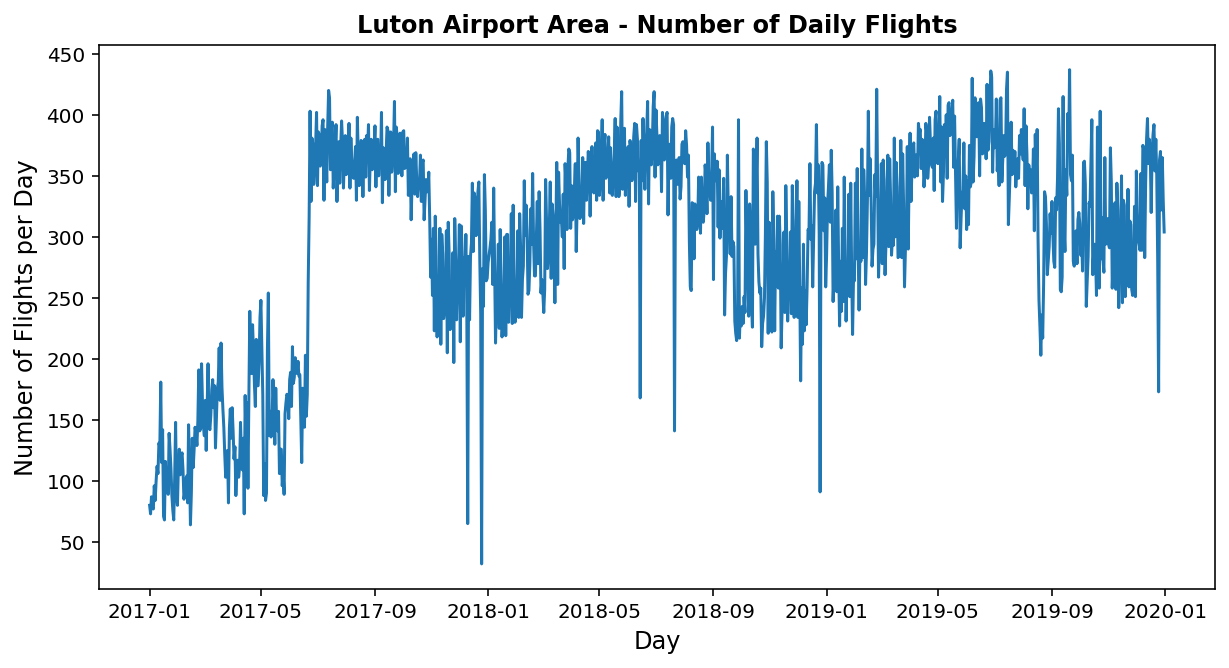

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))

summed_df = df.groupby(['timestamp'], as_index=False).agg({'count(icao24)':'sum'}).reset_index(drop=True)
ax.plot(summed_df['timestamp'], summed_df['count(icao24)'])
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Number of Flights per Day', fontsize=12)
ax.set_title('Luton Airport Area - Number of Daily Flights', fontweight='bold')

# Grid Data

A grid of 100px by 100px will be created and flights will be 'pixelated' to create a traffic map. Only an area of 5km by 5km around Luton Airport will be considered.

**PySpark Functions**

In [ ]:
from pyspark.sql.functions import udf

def calculate_west_east_distance(destination_longitude):
  return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
we_distance = udf(calculate_west_east_distance, FloatType())

def calculate_north_south_distance(destination_latitude):
  return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
ns_distance = udf(calculate_north_south_distance, FloatType())

def calculate_pixel_distance(destination_distance):
  return math.floor(destination_distance/grid_size)
px_distance = udf(calculate_pixel_distance, IntegerType())

def calculate_pixel_altitude(destination_altitude):
  altitude_level = math.floor((destination_altitude-160)/grid_size)
  if altitude_level >= 0:
    return altitude_level
  else:
    return 0
px_altitude = udf(calculate_pixel_altitude, IntegerType())

**Crop Dataset (To Create Map) Function**

In [ ]:
def crop_dataset(we_max, ns_max, grid_size, dataset):
  min_we_crop = int(we_max/2 - grid_size)
  max_we_crop = int(we_max/2 + grid_size)
  min_ns_crop = int(ns_max/2 - grid_size)
  max_ns_crop = int(ns_max/2 + grid_size)

  dataset = dataset[(dataset['we_px'] >= min_we_crop) &
                    (dataset['we_px'] <= max_we_crop) &
                    (dataset['ns_px'] >= min_ns_crop) &
                    (dataset['ns_px'] <= max_ns_crop)
                    ].reset_index(drop=True)

  dataset['we_px'] = dataset['we_px'] - min_we_crop
  dataset['ns_px'] = dataset['ns_px'] - min_ns_crop

  dataset = dataset[(dataset['we_px'] >= 0) &
                    (dataset['we_px'] < 100) &
                    (dataset['ns_px'] >= 0) &
                    (dataset['ns_px'] < 100)
                    ].reset_index(drop=True)

  return dataset

**Upsampler**

In [ ]:
import pandas as pd
import numpy as np
import math

def calculate_pixel_altitude(destination_altitude, grid_size):
  altitude_level = math.floor((destination_altitude-160)/grid_size)
  if altitude_level >= 0:
    return altitude_level
  else:
    return 0
import pandas as pd

def upsampler(dataframe, grid_size):
  subset = pd.DataFrame(columns=dataframe.columns.values.tolist())
  for i in range(0, len(dataframe)):
    try:
      a = (dataframe['we_distance'][i], dataframe['ns_distance'][i])
      b = (dataframe['we_distance'][i+1], dataframe['ns_distance'][i+1]) 
      d = np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

      if d > grid_size:
        iterations = math.ceil(d/(grid_size))
        for j in range(1, iterations):
          delta = j/iterations
          subset = subset.append(dataframe.iloc[[-1]]).reset_index(drop=True)
          subset.loc[subset.index[-1], 'time'] = dataframe['time'][i] + delta

          we_distance = a[0] + (b[0]-a[0]) * delta
          ns_distance = a[1] + (b[1]-a[1]) * delta
          subset.loc[subset.index[-1], 'we_distance'] = we_distance
          subset.loc[subset.index[-1], 'ns_distance'] = ns_distance
          subset.loc[subset.index[-1], 'we_px'] = math.floor(we_distance/grid_size)
          subset.loc[subset.index[-1], 'ns_px'] = math.floor(ns_distance/grid_size)

          geoalt_n = dataframe['geoaltitude'][i]
          geoalt_n1 = dataframe['geoaltitude'][i+1]
          subset.loc[subset.index[-1], 'geoaltitude'] = geoalt_n + (geoalt_n1-geoalt_n) * delta
          subset.loc[subset.index[-1], 'alt_px'] = calculate_pixel_altitude(geoalt_n + (geoalt_n1-geoalt_n) * delta, grid_size)

          subset.loc[subset.index[-1], 'lastposupdate'] = 0
          subset.loc[subset.index[-1], 'hour'] = dataframe['hour'][i]
          subset.loc[subset.index[-1], 'callsign'] = dataframe['callsign'][i]
    except:
      pass

  return pd.concat([dataframe, subset]).sort_values(by=['time']).reset_index(drop=True)

**Preprocess Data**

In [ ]:
from datetime import timezone
from datetime import datetime
from haversine import haversine, Unit, inverse_haversine
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
import math
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import numpy as np
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output
from pyspark.sql.functions import udf
import os
# from upsampler import upsampler

def preprocess_data(year, month, airport, diag_distance=4, grid_size=50):
  min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
  max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
  min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

  we_dist = haversine(min_coord, (min_lat, max_lon), unit=Unit.METERS)
  ns_dist = haversine(min_coord, (max_lat, min_lon), unit=Unit.METERS)

  def calculate_west_east_distance(destination_longitude):
    return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
  we_distance = udf(calculate_west_east_distance, FloatType())

  def calculate_north_south_distance(destination_latitude):
    return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
  ns_distance = udf(calculate_north_south_distance, FloatType())

  def calculate_pixel_distance(destination_distance):
    return math.floor(destination_distance/grid_size)
  px_distance = udf(calculate_pixel_distance, IntegerType())

  def calculate_pixel_altitude(destination_altitude):
    altitude_level = math.floor((destination_altitude-160)/grid_size)
    if altitude_level >= 0:
      return altitude_level
    else:
      return 0

  px_altitude = udf(calculate_pixel_altitude, IntegerType())

  # Query
  days = np.linspace(1,31,31)
  grid_size = 50 # in metres

  for day in tqdm(days):
    hour_start = datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
    hour_end = datetime(year, month, int(day), 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

    day_subset = opensky_df.where(
                                  (opensky_df.lat >= min_lat) &
                                  (opensky_df.lat < max_lat) &
                                  (opensky_df.lon >= min_lon) &
                                  (opensky_df.lon < max_lon) &
                                  (opensky_df.geoaltitude >= 0) & 
                                  (opensky_df.geoaltitude < 1000) &
                                  (opensky_df.hour >= hour_start) &
                                  (opensky_df.hour <= hour_end)
                                )

    # def epoch_to_utc(hour_in_unix_time):
    #   return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
    # utc = udf(epoch_to_utc, DateType())

    # opensky_df = opensky_df.withColumn('timestamp', utc('hour'))
    # opensky_df = opensky_df.withColumn('altitude', ft_to_m('geoaltitude'))
    day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
    day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
    day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
    day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
    day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

    epoch_hour = hour_start # start hour
    # hour_subset = upsampler(day_subset.toPandas()).groupby(['hour', 'alt_px', 'ns_px', 'we_px']).agg({'callsign': 'count'}).reset_index()
    hour_subset = day_subset.toPandas()

    cmap = plt.cm.get_cmap('brg', 10)
    for i in range(0, 24):
      matrix = np.zeros((20,100,100))

      image_subset = hour_subset[hour_subset['hour'] == int(epoch_hour)].reset_index(drop=True)
      # image_subset = image_subset.groupby(['alt_px', 'ns_px', 'we_px']).agg({'icao24': 'count'}).reset_index()
      callsigns = image_subset.groupby('callsign')['time'].count().reset_index()['callsign'].tolist()
      try: # Some image_subset could be 0 length
        for callsign in callsigns:
          callsign_filtered = image_subset[image_subset['callsign'] == callsign].reset_index(drop=True)
          callsign_filtered = upsampler(callsign_filtered, grid_size)
          callsign_filtered = crop_dataset(int(we_dist/grid_size), int(we_dist/grid_size), grid_size, callsign_filtered)

          for j in range(0, len(callsign_filtered)):
              matrix[callsign_filtered['alt_px'][j]][callsign_filtered['ns_px'][j]][callsign_filtered['we_px'][j]] = 1

      except:
        pass
      
      # cmap = mpl.colors.ListedColormap(['black','white', 'blue', 'green', 'yellow'])
      max_matrix = np.amax(matrix, axis = 0)
      img = plt.imshow(max_matrix, cmap = plt.get_cmap('plasma'), origin='lower')
      plt.show()
      
      # Save
      working_folder = f'{home_folder}/dataset/{year}-{str(month).zfill(2)}/{year}-{str(month).zfill(2)}-{str(int(day)).zfill(2)}'

      if not os.path.exists(f'{working_folder}'):
        os.makedirs(f'{working_folder}')

      if not os.path.exists(f'{working_folder}/img'):
        os.makedirs(f'{working_folder}/img')
      
      np.save(f'{working_folder}/{int(epoch_hour)}.npy', matrix)
      plt.imsave(f'{working_folder}/img/{int(epoch_hour)}.png', max_matrix, origin='lower')

      print(f'\nCompleted: {int(epoch_hour)}')
      epoch_hour += 3600


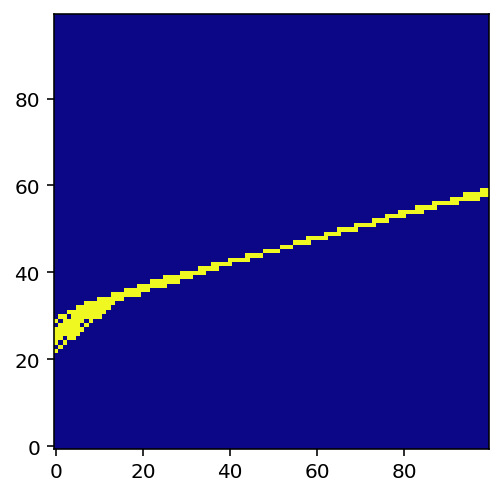


Completed: 1513537200


In [ ]:
from IPython.display import clear_output

airport = (51.87626460000001, -0.3717470999999932) # Luton
for i in range(11,13):
  try:
    preprocess_data(year=2017, month=i, airport=airport)
  except:
    pass
  clear_output(wait=True)

# Visualize a Specific Day

**Apply Query**

In [ ]:
year = 2018
month = 7
day = 10
hour_lookup = 1531188000

In [ ]:
from datetime import timezone
from datetime import datetime
import math
import numpy as np
from haversine import haversine, Unit, inverse_haversine

# Calculate distances to airport
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 4
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])
grid_size = 50

hour_start = datetime(year, month, day, 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
hour_end = datetime(year, month, day, 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

day_subset = opensky_df.where(
                              (opensky_df.lat >= min_lat) &
                              (opensky_df.lat < max_lat) &
                              (opensky_df.lon >= min_lon) &
                              (opensky_df.lon < max_lon) &
                              (opensky_df.geoaltitude >= 0) & 
                              (opensky_df.geoaltitude < 1000) &
                              (opensky_df.hour >= hour_start) &
                              (opensky_df.hour <= hour_end)
                            )

day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

pd_image_subset = day_subset.where(
                                    (day_subset.hour == hour_lookup)
                                  ).toPandas()
pd_image_subset

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,geoaltitude,lastposupdate,lastcontact,hour,timestamp,we_distance,ns_distance,we_px,ns_px,alt_px
0,1531189053,40660e,51.880932,-0.331192,72.289909,253.886581,-3.57632,TOM235,False,False,...,297.179993,1.531189e+09,1.531189e+09,1531188000,2018-07-10,5614.011230,3348.202393,112,66,2
1,1531189054,40660e,51.880795,-0.332260,72.289909,253.886581,-3.57632,TOM235,False,False,...,289.559998,1.531189e+09,1.531189e+09,1531188000,2018-07-10,5540.645996,3332.931885,110,66,2
2,1531189055,40660e,51.880600,-0.333301,72.148819,254.279068,-3.57632,TOM235,False,False,...,281.940002,1.531189e+09,1.531189e+09,1531188000,2018-07-10,5469.121094,3311.299072,109,66,2
3,1531189056,40660e,51.880417,-0.334341,72.011139,254.673080,-3.90144,TOM235,False,False,...,281.940002,1.531189e+09,1.531189e+09,1531188000,2018-07-10,5397.739746,3290.938721,107,65,2
4,1531189057,40660e,51.880234,-0.335380,72.507408,254.780533,-3.57632,TOM235,False,False,...,274.320007,1.531189e+09,1.531189e+09,1531188000,2018-07-10,5326.358398,3270.578125,106,65,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,1531189367,40660e,51.877945,-0.349261,71.515121,254.564133,-3.25120,TOM235,False,False,...,228.600006,1.531189e+09,1.531189e+09,1531188000,2018-07-10,4372.895508,3016.072754,87,60,1
315,1531189368,40660e,51.877945,-0.349261,71.515121,254.564133,-3.25120,TOM235,False,False,...,228.600006,1.531189e+09,1.531189e+09,1531188000,2018-07-10,4372.895508,3016.072754,87,60,1
316,1531189369,40660e,51.877945,-0.349261,71.515121,254.564133,-3.25120,TOM235,False,False,...,228.600006,1.531189e+09,1.531189e+09,1531188000,2018-07-10,4372.895508,3016.072754,87,60,1
317,1531189370,40660e,51.877945,-0.349261,71.515121,254.564133,-3.25120,TOM235,False,False,...,228.600006,1.531189e+09,1.531189e+09,1531188000,2018-07-10,4372.895508,3016.072754,87,60,1


In [ ]:
day_subset.toPandas()

In [ ]:
pd_image_subset.to_excel('pd_image_subset.xlsx')  

**Callsigns Present in Query**

In [ ]:
# callsigns = pd_image_subset.groupby('callsign')['time'].count().reset_index()['callsign'].tolist()
callsigns = pd_image_subset.groupby('icao24')['time'].count().reset_index()['icao24'].tolist()
callsigns

['40660e']

**Plot Flights**

<Figure size 432x288 with 0 Axes>

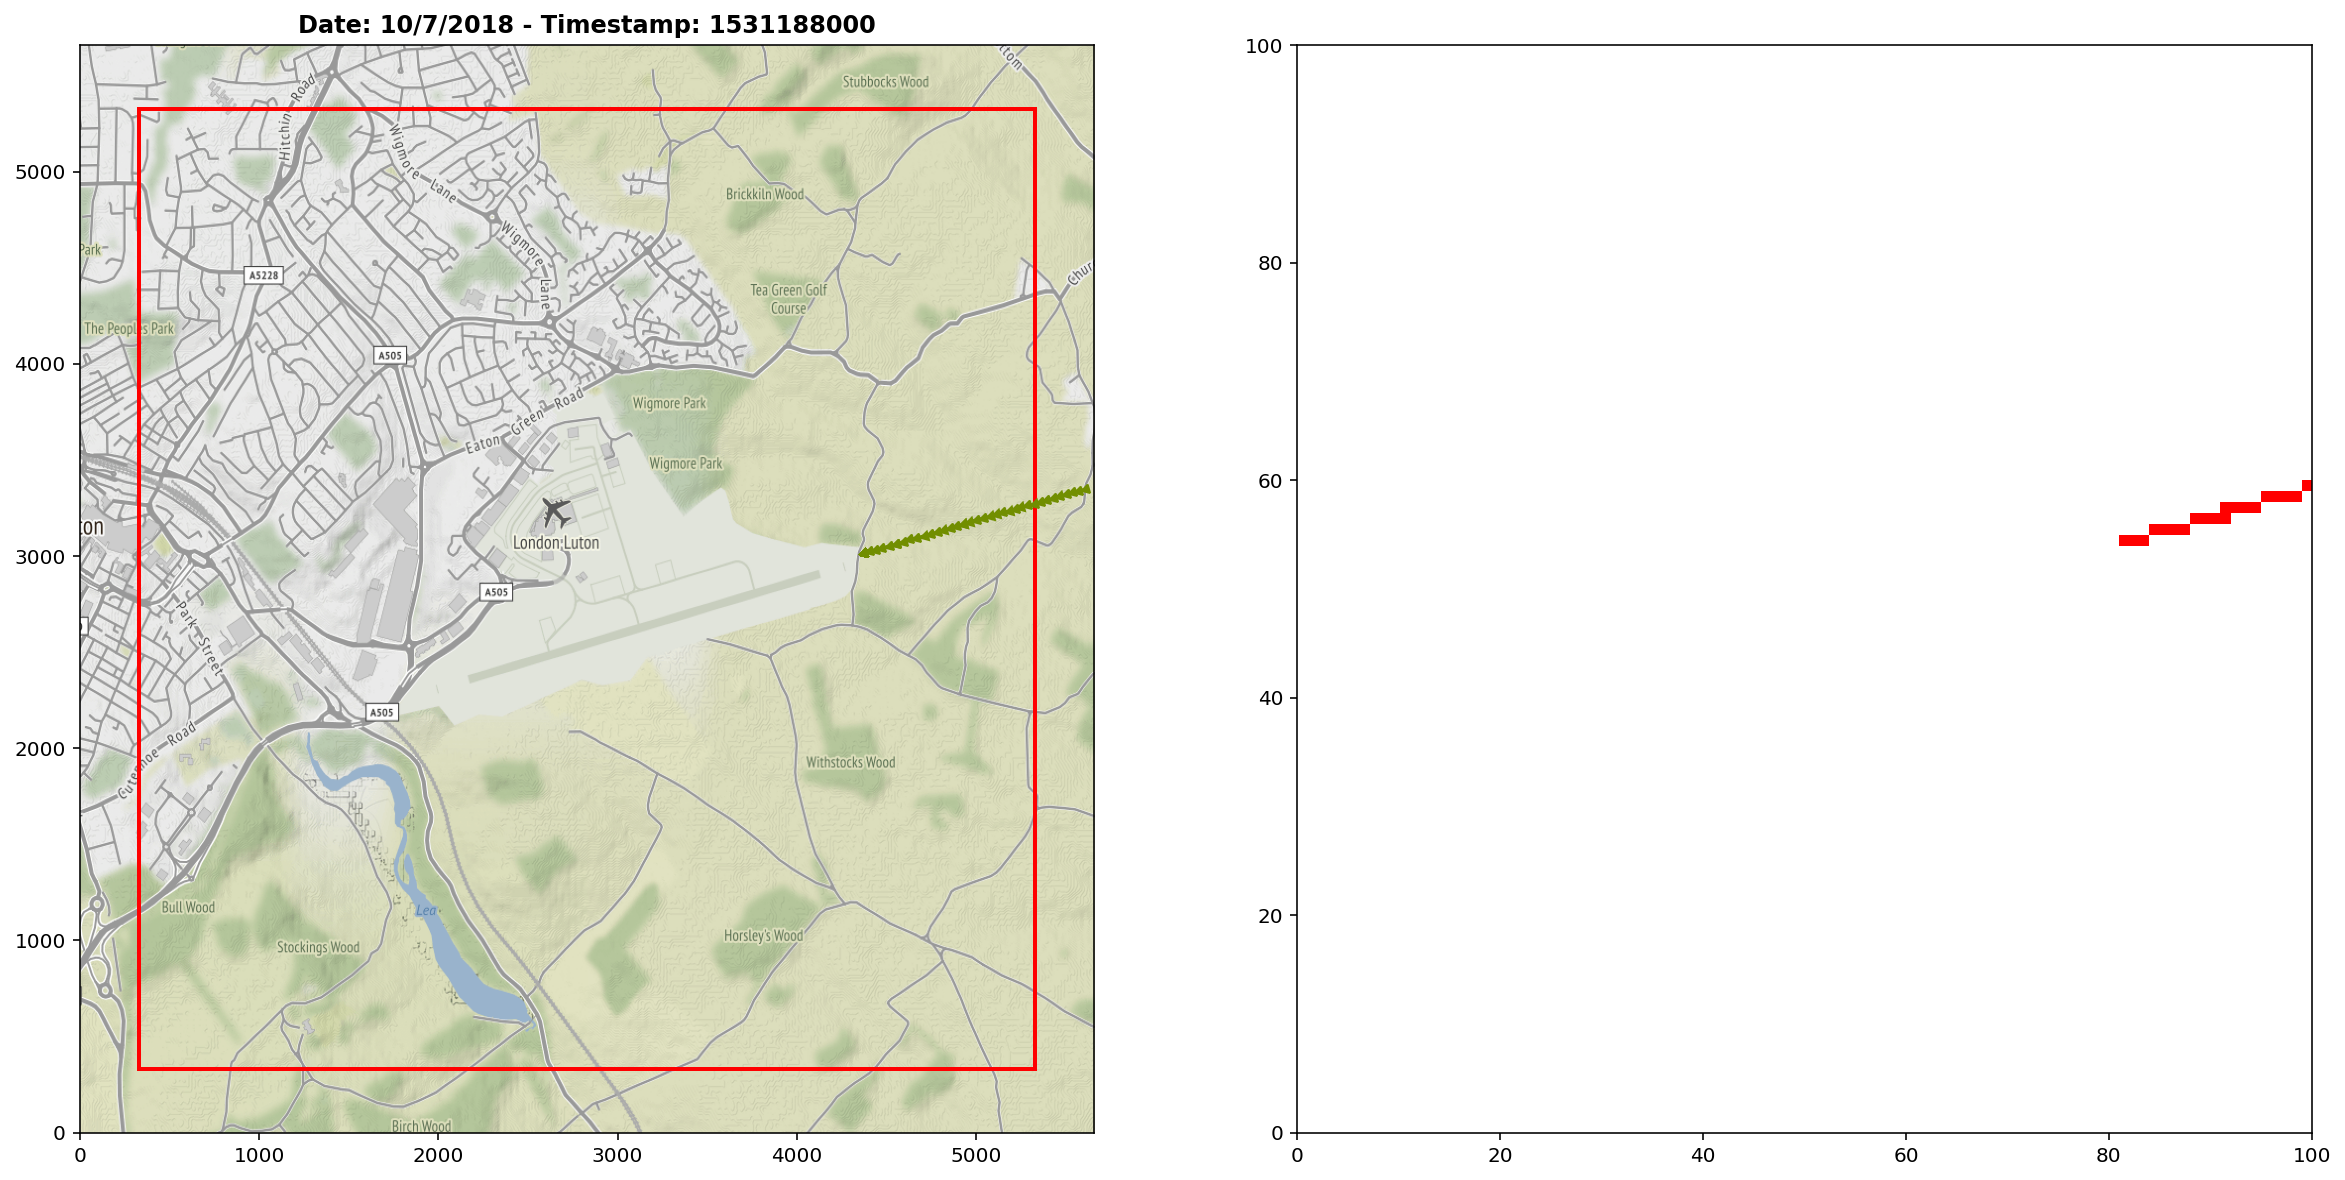

In [ ]:
import contextily as cx
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
# from upsampler.upsampler import upsampler
%config InlineBackend.figure_format = 'retina'

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,10))

grid_size = 50 # in metres

ghent_img, ghent_ext = cx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=cx.providers.Stamen.Terrain)
we_dist = haversine(min_coord, (min_lat, max_lon), unit=Unit.METERS)
ns_dist = haversine(min_coord, (max_lat, min_lon), unit=Unit.METERS)

ax[0].imshow(ghent_img, extent=(0, we_dist, 0, ns_dist))
we_center = we_dist/2
ns_center = ns_dist/2
we_min = we_center - 2500
ns_min = ns_center - 2500

rect = patches.Rectangle((we_min, ns_min), 5000, 5000, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].set_xlim([0, 100])
ax[1].set_ylim([0, 100])

cmap = plt.cm.get_cmap('brg', 10)
for callsign in callsigns:
  # callsign_subset = pd_image_subset[pd_image_subset['callsign'] == callsign].reset_index(drop=True)
  callsign_subset = pd_image_subset[pd_image_subset['icao24'] == callsign].reset_index(drop=True)
  callsign_subset = upsampler(callsign_subset, grid_size)
  callsign_subset_mod = crop_dataset(int(we_dist/grid_size), int(we_dist/grid_size), grid_size, callsign_subset)
  color_index = random.randint(0, 10)
  ax[0].plot(callsign_subset['we_distance'], callsign_subset['ns_distance'], color=cmap(color_index))

  for k in range(0, len(callsign_subset)):
    ax[0].plot(callsign_subset['we_distance'][k], callsign_subset['ns_distance'][k], '-', marker=(3, 0, -callsign_subset['heading'][k]), markersize=5, color = cmap(color_index))
    # rect = patches.Rectangle((callsign_subset['we_px'][k]*grid_size, callsign_subset['ns_px'][k]*grid_size), grid_size, grid_size, facecolor='red', alpha=1)
    # ax[0].add_patch(rect)

  for m in range(0, len(callsign_subset_mod)):
    rect2 = patches.Rectangle((callsign_subset_mod['we_px'][m], callsign_subset_mod['ns_px'][m]), 1, 1, facecolor='red', alpha=1)
    ax[1].add_patch(rect2)

ax[0].set_title(f'Date: {day}/{month}/{year} - Timestamp: {hour_lookup}', fontweight='bold')
ax[0].set_aspect('auto')

# ax.grid(color='black', linewidth = 1, which='both')
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)